In [1]:
%pip install transformers
import torch
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import BertTokenizer, BertModel
from transformers import logging
logging.set_verbosity_error()

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Mod(torch.nn.Module):
  def __init__(self, num_hidden, num_outs):
    super().__init__()
    
    self.fc1 = torch.nn.Linear(768,num_hidden)
    
    #self.fc2 = torch.nn.Linear(500,num_hidden)
    self.drop = torch.nn.Dropout(0.33)
    self.hidden = torch.nn.Linear(num_hidden,num_outs)

  def forward(self,x):
   # x = self.pool(x)
    x = torch.nn.functional.relu(self.fc1(x))
    #x = torch.nn.Dropout(0.2)(x)
    x = self.drop(x)
   
    #x = torch.nn.functional.relu(self.fc2(x))
    #x = torch.nn.Dropout(0.2)(x)
    return self.hidden(x)

device = "cuda:0" #might need to change this or add an if cuda.is_available() before it
model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load("model_trained_on_fakeddit.pt"))#,state_dict="state_dict")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss() #I don't think the paper mentioned loss function used
epochs = 20

#Things to tune would be epochs, learning rate for adam, number of hidden layers
#Haven't implemented use of validation set yet

In [5]:

test2df = pd.read_csv('fake-real-testsplit.tsv', delimiter='\t')



In [6]:
from torch import tensor
import regex as re
def converter(x):
    return eval(x)
    







In [7]:
test2df['embedding'] = test2df['embedding'].apply(converter)





In [8]:

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))#change depending on 2 3 6 way
testloader = DataLoader(testset)
print(len(testloader))
import os
model = Mod(300,2).to(device)
model.load_state_dict(torch.load("model_trained_FNC_Fake.pt"))

60000


<All keys matched successfully>

0.06812518164669766
[0.06872761 0.26962583 0.36697751 0.42072409 0.47007397 0.52173913
 0.61986511 0.67594538 0.74472727 0.94099365] [0.01296258 0.14558995 0.24798895 0.34905836 0.4486311  0.54990337
 0.65019308 0.75154809 0.85430117 0.98667857]


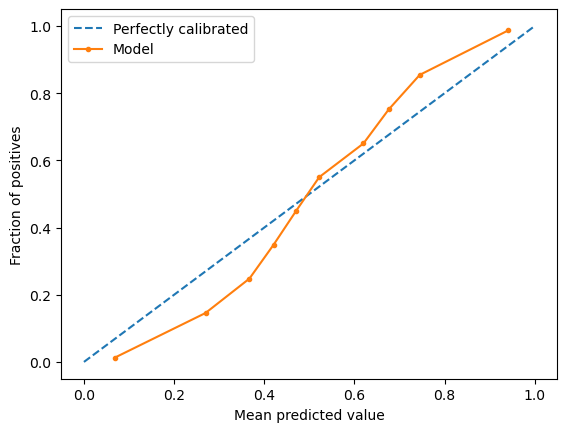

In [38]:
import sklearn.calibration
import numpy as np
import matplotlib.pyplot as plt
model.eval()
test_outputs = model(torch.stack(list(test2df['embedding'])))
test_outputs = torch.softmax(test_outputs, dim =2)
test_outputs = test_outputs[:,:,1].cpu()

predictions = test_outputs.detach().numpy().flatten()

# Calculate the calibration curve

bins = np.linspace(0, 1, num=10)
mean_predicted_value, fraction_of_positives = sklearn.calibration.calibration_curve(((test2df['label'])), predictions, n_bins=10)
ece = 0
for i in range(len(mean_predicted_value)):
    ece += np.abs(mean_predicted_value[i] - fraction_of_positives[i])/10
print(ece)



# Plot the calibration curve
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax.plot(mean_predicted_value, fraction_of_positives, marker='.', label='Model')
ax.set_xlabel('Mean predicted value')
ax.set_ylabel('Fraction of positives')
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.show()
